# Linear Regression VS Bayesian Regression

## Key Differences
- Bayesian models provide uncertainty estimates, which are important in determining how our model performs (how robust our model is) under certain parameter values.
- Under a Bayesian framework, we can encode knowledge about parameters to supplement the model. For example, consider this toy problem: we are trying to find the error in a piece of apparatus that measures the acceleration of objects. We gather data by measuring dropping objects from a height and measuring their acceleration - which should be close to gravity. This "knowledge" about what the acceleration should be can be encoded into a Bayesian model, but cannot be used in a frequentist model.

In [36]:
#hide
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [37]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

df = df[np.isfinite(df.rgdppc_2000)] # remove NaNs
df["rgdppc_2000"] = np.log(df["rgdppc_2000"]) # log real GPD per capita

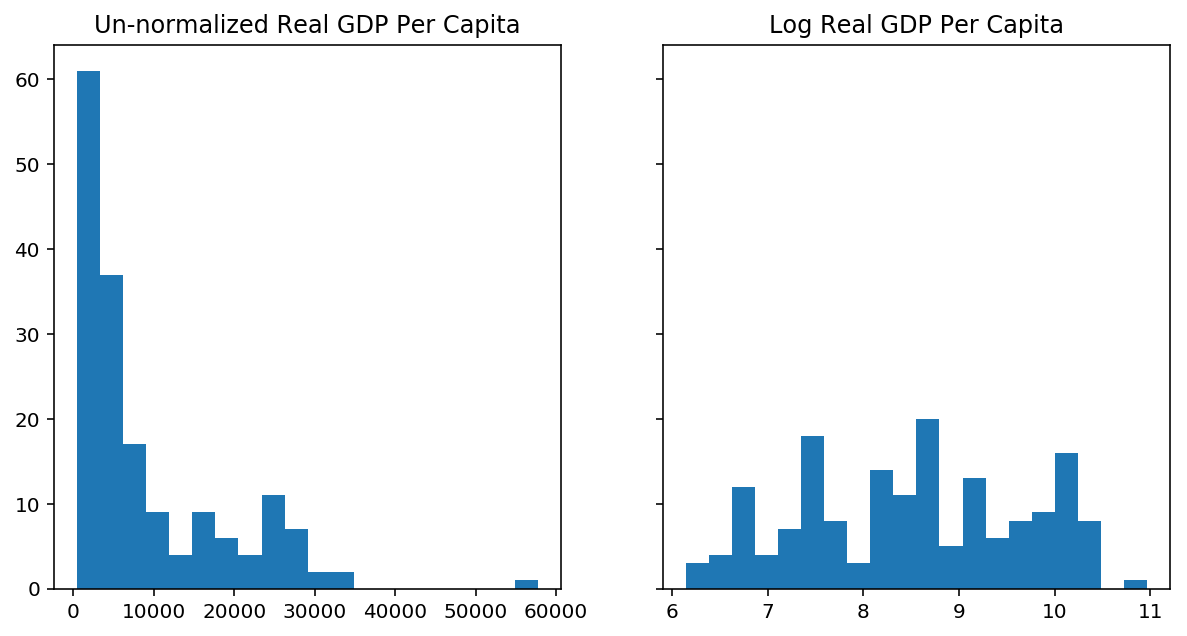

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
ax[0].hist(data[np.isfinite(data.rgdppc_2000)].rgdppc_2000, bins = 20)
ax[0].set(title="Un-normalized Real GDP Per Capita")
ax[1].hist(df.rgdppc_2000, bins = 20)
ax[1].set(title="Log Real GDP Per Capita");

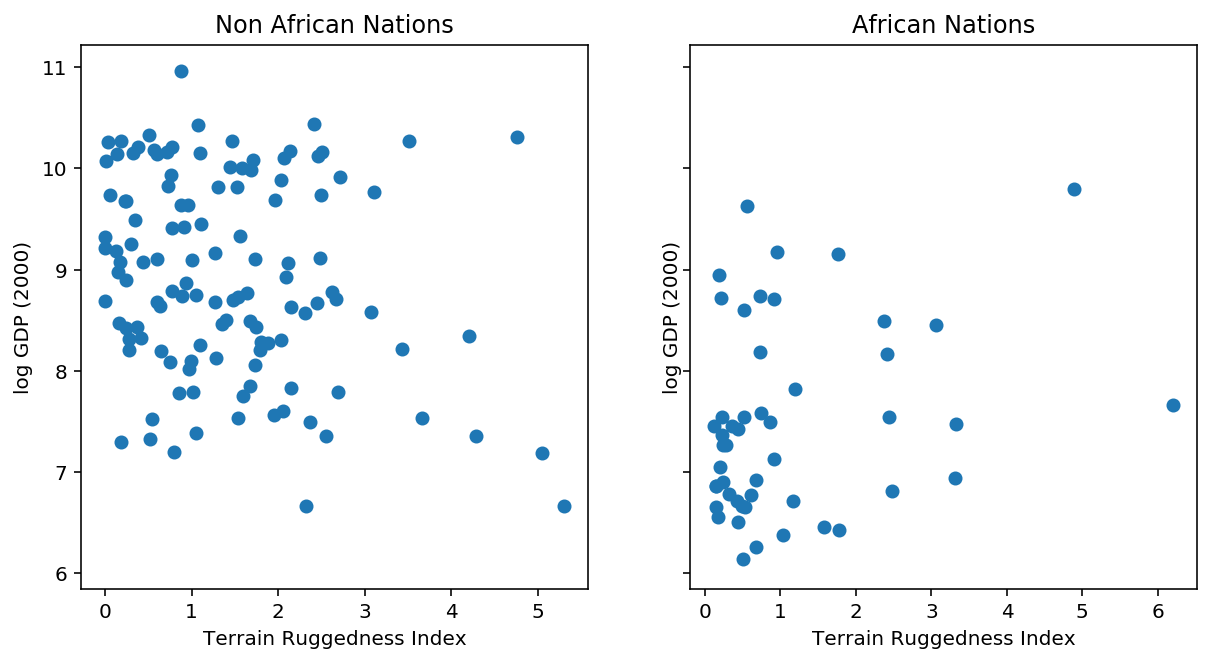

In [39]:
# add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]

african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
ax[0].scatter(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].scatter(african_nations["rugged"],
                african_nations["rgdppc_2000"])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

### Simple Linear Regression

In [29]:
features = ["rugged", "cont_africa_x_rugged", "cont_africa"]
x = df[features]
y = df["rgdppc_2000"]

reg = LinearRegression()
_ = reg.fit(x, y)

coef = dict([i for i in zip(list(x.columns), reg.coef_)]); coef
print("Intercept: %f" % reg.intercept_)
print("Coefficient of Determination: %f" % reg.score(x, y))

{'rugged': -0.20285708606709807,
 'cont_africa_x_rugged': 0.393393801193117,
 'cont_africa': -1.9480479960116401}

Intercept: 9.223226
Coefficient of Determination: 0.356925


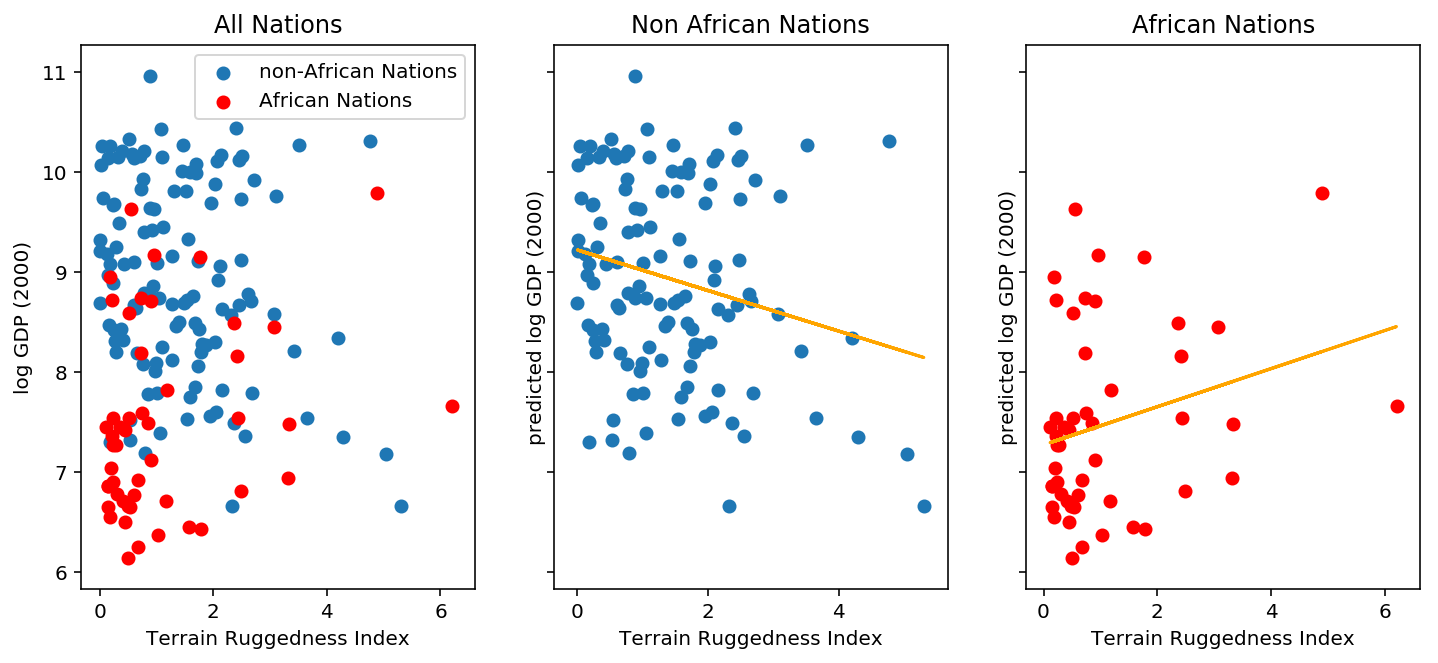

In [34]:
# predict GPD from continent and terrain
african_gdp = reg.predict(african_nations[features])
non_african_gdp = reg.predict(non_african_nations[features])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5), sharey=True)
ax[0].scatter(non_african_nations["rugged"],
              non_african_nations["rgdppc_2000"],
              label="non-African Nations")
ax[0].scatter(african_nations["rugged"],
              african_nations["rgdppc_2000"],
              color = "red",
              label="African Nations")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="All Nations");
ax[0].legend()

ax[1].plot(non_african_nations["rugged"],
           non_african_gdp,
           color = "orange")
ax[1].scatter(non_african_nations["rugged"],
              non_african_nations["rgdppc_2000"])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="predicted log GDP (2000)",
          title="Non African Nations")

ax[2].plot(african_nations["rugged"],
           african_gdp,
           color = "orange")
ax[2].scatter(african_nations["rugged"],
              african_nations["rgdppc_2000"],
              color = "red")
ax[2].set(xlabel="Terrain Ruggedness Index",
          ylabel="predicted log GDP (2000)",
          title="African Nations");

In [35]:
# backout the slopes of lines for nations in and out of Africa
print("Slope for African nations: ", coef["rugged"] + coef["cont_africa_x_rugged"])
print("Slope for non-African nations: ", coef["rugged"])

Slope for African nations:  0.19053671512601894
Slope for non-African nations:  -0.20285708606709807


### Questions
- Do we have a better way of determining if the there's a difference in the effect of terrain?
    - We can look at the slopes of the regression lines for Africa and non-Africa.

## Bayesian Regression with Pyro

We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable `rugged` in the dataset) and its GDP per capita. Terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data and investigate this relationship. We will be focusing on three features from the dataset: 
- `rugged`: quantifies the Terrain Ruggedness Index 
- `cont_africa`: whether the given nation is in Africa 
- `rgdppc_2000`: Real GDP per capita for the year 2000

In [8]:
#hide
from functools import partial
import torch

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule

### Bayesian Regression with Stochastic Variational Inference

We need to put priors on our parameters (weight + bias) in order to make the model Bayesian.

In [105]:
from pyro.nn import PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

Making a Bayesian model for linear regression is very intuitive using PyroModule as earlier. Note the following:

- The `BayesianRegression` module internally uses the same `PyroModule[nn.Linear]` module. However, note that we replace the `weight` and the `bias` of the this module with `PyroSample` statements. These statements allow us to place a prior over the `weight` and `bias` parameters, instead of treating them as fixed learnable parameters. For the bias component, we set a reasonably wide prior since it is likely to be substantially above 0.
- The `BayesianRegression.forward` method specifies the generative process. We generate the mean value of the response by calling the linear module (which samples the weight and bias parameters from the prior and returns a value for the mean response). Finally we use the `obs` argument to the `pyro.sample` statement to condition on the observed data `y_data` with a learned observation noise `sigma`. The model returns the regression line given by the variable mean.

In [106]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        # PyroSample is used to declare priors:
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

To begin with, we will use the `AutoDiagonalNormal` guide that models the distribution of unobserved parameters in the model as a Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables. Under the hood, this defines a guide that uses a Normal distribution with learnable parameters corresponding to each `sample` statement in the model. In our case, this distribution should have a size of (5,) correspoding to the 3 regression coefficients for each of the terms, and 1 component contributed each by the intercept term and sigma in the model.

We'll also use the ELBO loss function here as opposed to the MSE used before.

In [107]:
auto_guide = AutoDiagonalNormal(BayesianRegression(3, 1))
svi = SVI(model = BayesianRegression(3, 1), # bayesian regression class  
          guide = auto_guide, # using auto guide
          optim = pyro.optim.Adam({"lr": 0.03}),
          loss=Trace_ELBO())

In [108]:
num_iterations = 2500
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 4.0412
[iteration 0101] loss: 2.5270
[iteration 0201] loss: 1.7726
[iteration 0301] loss: 1.4635
[iteration 0401] loss: 1.4664
[iteration 0501] loss: 1.4566
[iteration 0601] loss: 1.4770
[iteration 0701] loss: 1.4718
[iteration 0801] loss: 1.4652
[iteration 0901] loss: 1.4907
[iteration 1001] loss: 1.4567
[iteration 1101] loss: 1.4595
[iteration 1201] loss: 1.4714
[iteration 1301] loss: 1.4585
[iteration 1401] loss: 1.4678
[iteration 1501] loss: 1.4702
[iteration 1601] loss: 1.4657
[iteration 1701] loss: 1.4629
[iteration 1801] loss: 1.4580
[iteration 1901] loss: 1.4674
[iteration 2001] loss: 1.4716
[iteration 2101] loss: 1.4619
[iteration 2201] loss: 1.4887
[iteration 2301] loss: 1.4733
[iteration 2401] loss: 1.4573


In [109]:
auto_guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal()

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2693, -1.8370, -0.1964,  0.3043,  9.1820])
AutoDiagonalNormal.scale tensor([0.0615, 0.1746, 0.0426, 0.0829, 0.0771])


In [113]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.025), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.975), dim=0)[0],
        }
    return site_stats


predictive = Predictive(BayesianRegression(3, 1), 
                        guide=auto_guide, 
                        num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [114]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})
predictions.head()

,cont_africa,rugged,mu_mean,mu_perc_5,mu_perc_95,y_mean,y_perc_5,y_perc_95,true_gdp
0,1.0,0.858,7.438475,7.058918,7.823476,7.469077,5.494361,9.304463,7.492610
1,0.0,3.427,8.509052,8.210452,8.842378,8.535964,6.590622,10.332006,8.216929
2,0.0,0.769,9.032236,8.856190,9.194511,9.010691,7.177060,10.848734,9.933263
3,0.0,0.775,9.031054,8.855026,9.193749,9.000296,7.234594,10.805919,9.407031
4,0.0,2.688,8.654503,8.399582,8.936316,8.640403,6.768952,10.433353,7.792343


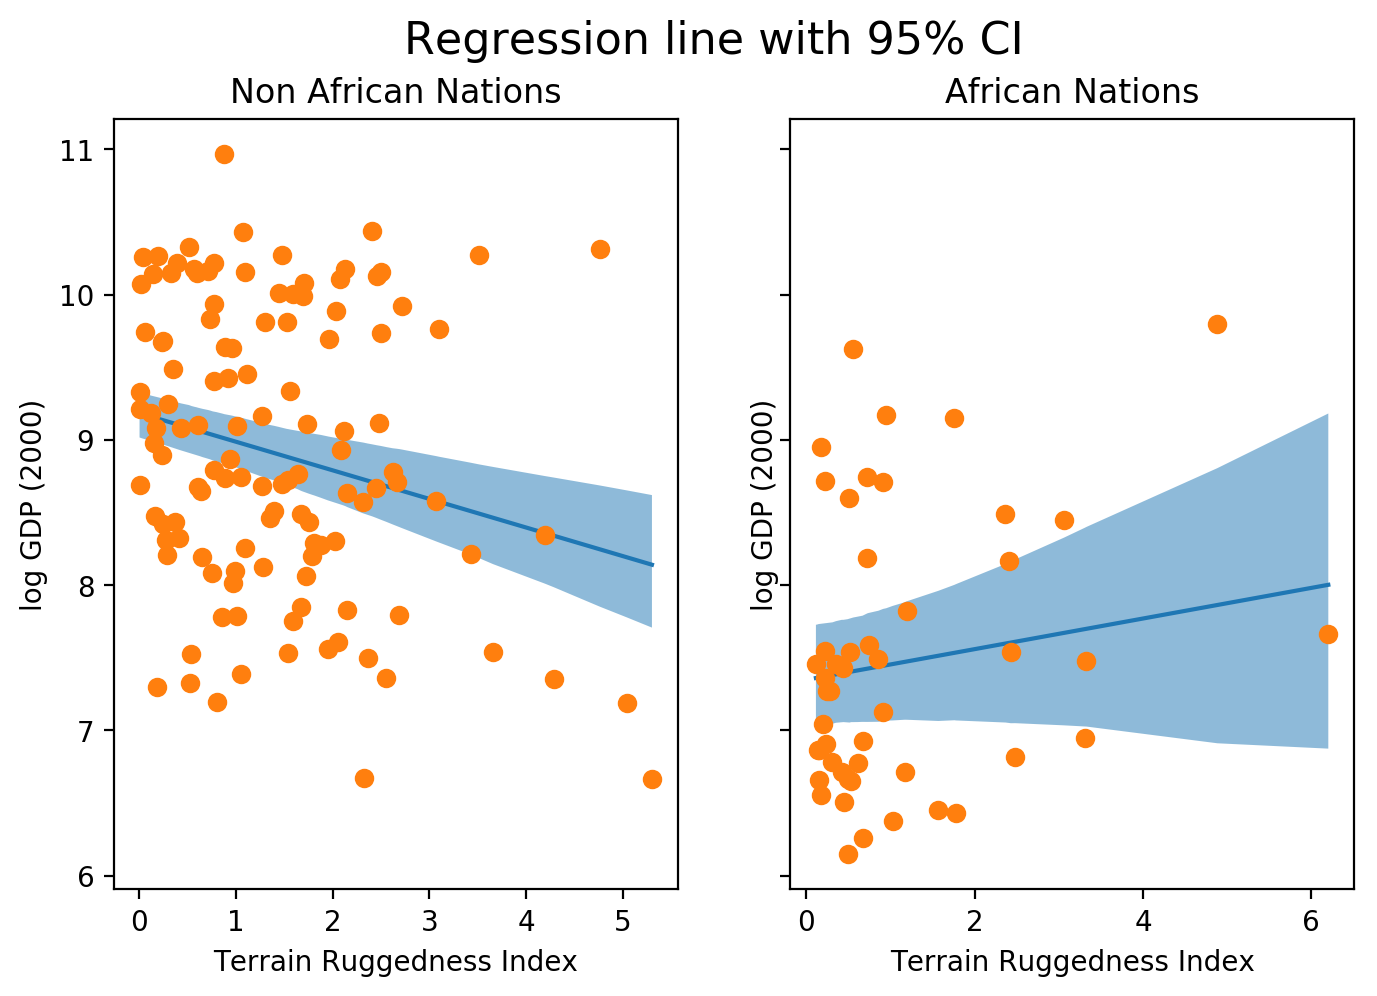

In [117]:
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharey=True)
fig.suptitle("Regression line with 95% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

We can look at the distribution of slope of log GDP given terrain ruggedness for nations within and outside Africa.

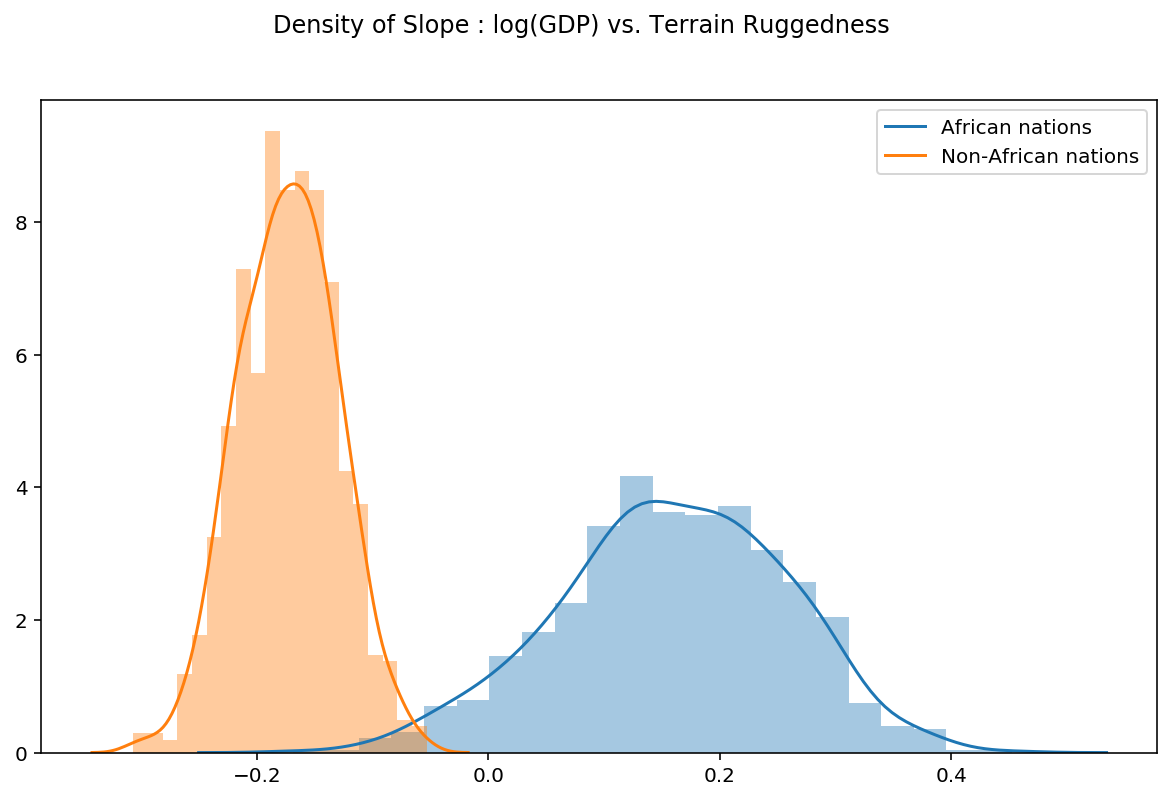

In [70]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]

fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

## Resources
- http://www.gaussianprocess.org/gpml/chapters/RW.pdf
- http://www.greenteapress.com/thinkbayes/thinkbayes.pdf
- https://pyro.ai/examples/bayesian_regression.html#Linear-Regression